In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from statsmodels.distributions.empirical_distribution import ECDF
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Problem definition

# <center>Project: Indoor Localization.</center>


Data : uploaded in Moodle
- train set (offline) and 
- separated (online) test set

Citation for the data: Thomas King, Stephan Kopf, Thomas Haenselmann, Christian Lubberger, Wolfgang Effelsberg, mannheim/compass, https://doi.org/10.15783/C7F30Q , Date: 20060913

## Introduction 
Recall the ML Project workflow.

Problem understanding
Data collection, Data Cleaning and Exploration
Feature Selection, Feature Engineering
Training and Model Selection
Evaluation and Deployment

## Problem Description
- Indoor localization is different than outdoor, because 
    - no line of sight, lots of distorting factors
    - needs more precision
- Examples of Applications:  
    - Logistics, Customer Support (saving time shopping), Hospitals (Patients, Device Location tracking)
- Variety of positioning technologies
    - WiFi based approaches: Received Signal Strength (RSS), angle, time of arrival, time difference of arrival
    - Bluetooth 
    - Radio Frequency
    - ...
- Challenges: 
    - poor accuracy
    - high computational complexity 
    - costs of hardware

Task: Search for a Survey paper and list some approaches present in the literature 

Task: Formulate the Problem Description, Challanges and Ml formulation

## Our project: Localization based on Received Signal Strength(RSS), using k-NN

In this project, we will work on 
  - understanding and cleaning the data,
  - organizing it in a structure suitable for analysis, and 
  - examining its statistical properties 
  - We will use a k-NN model to predict the location of new data points
  - Hyper parameter tuning, model selection

## 2. Data

Quelle des Datensatzes: https://ieee-dataport.org/open-access/crawdad-mannheimcompass-v-2008-04-11

Die Messungen wurden in einem Bürogebäude auf dem Campus der Universität Mannheim durchgeführt. Das Testgebiet umfasst einen Flur mit ca. 15 m Breite und 36 m Länge (≈ 312 m²). Auf dem Grundrissplan sind die Referenzpunkte (helle Punkte), Messpunkte (dunkle Punkte) und Access Points (schwarze Quadrate) eingezeichnet. Siehe Bild

<div style="text-align: center;">
  <img title="a title" alt="Alt text" src="../img/building.jpg">
</div>

Das im Operationsgebiet angelegte Referenzpunktraster umfasst 166 Punkte im Abstand von einem Meter (siehe helle Punkte in der Grundrissabbildung). Während der Offline-Phase wurde die Signalstärke an Referenzpunkten für verschiedene Orientierungen gemessen. Anschließend wurden 60 Koordinaten und Orientierungen zufällig für die Online-Phase ausgewählt.

Heißt wir haben 2 Datensätze offline (train) und online (test). 

## Offline Data

- Ort & Methode: Es wurde ein Gitter mit 166 Referenzpunkten im Messbereich (1 Meter Abstand) markiert.
- Messung: An jedem Punkt und in mehreren Ausrichtungen wurden jeweils 110 Messungen durchgeführt.
- Datenmenge: Insgesamt 146.080 Signalstärkemessungen
- Verwendung: Diese Daten bilden die Grundlage für das Positionsmodell (Offline-Phase).

In [3]:
with open("offline.final.trace.txt", "r") as file:
    lines = [line.strip() for line in file if not line.startswith("#")]

len(lines) == 166 * 8 * 110, len(lines)

(True, 146080)

## Online Data

- Ort & Methode: Zufällig ausgewählte 60 Punkte innerhalb des Testgebiets. Bedingung: Jeder Punkt musste von vier Referenzpunkten umgeben sein.

- Messung: Auch hier 110 Messungen pro Punkt

- Datenmenge: Insgesamt 6.600 Signalstärkemessungen

- Verwendung: Diese Daten simulieren die reale Nutzung – das Gerät kennt seine Position nicht und versucht, sie mit dem Offline-Datensatz zu schätzen.


In [4]:
with open("online.final.trace.txt", "r") as file:
    lines = [line.strip() for line in file if not line.startswith("#")]

len(lines)

6592

Wir müssen die Textdatei in ein Dataframe für die weitere Verarbeitung konvertieren. Sehen wir uns eine Zeile an. 

In [5]:
lines[1:5]

['t=1139692477555;id=00:02:2D:21:0F:33;pos=0.0,0.05,0.0;degree=130.5;00:14:bf:b1:97:8a=-43,2437000000,3;00:14:bf:b1:97:8a=-43,2437000000,3;00:0f:a3:39:e1:c0=-52,2462000000,3;00:14:bf:b1:97:90=-57,2427000000,3;00:14:bf:b1:97:8d=-64,2442000000,3;00:0f:a3:39:e0:4b=-77,2462000000,3;00:0f:a3:39:dd:cd=-62,2412000000,3;02:00:42:55:31:00=-85,2457000000,1;02:64:fb:68:52:e6=-88,2447000000,1',
 't=1139692477807;id=00:02:2D:21:0F:33;pos=0.0,0.05,0.0;degree=130.5;00:0f:a3:39:e1:c0=-51,2462000000,3;00:14:bf:b1:97:90=-49,2427000000,3;00:14:bf:3b:c7:c6=-62,2432000000,3;00:14:bf:b1:97:8a=-44,2437000000,3;00:14:bf:b1:97:81=-68,2422000000,3;00:0f:a3:39:e0:4b=-75,2462000000,3;00:0f:a3:39:dd:cd=-66,2412000000,3;00:0f:a3:39:e2:10=-90,2437000000,3;02:00:42:55:31:00=-87,2457000000,1',
 't=1139692478059;id=00:02:2D:21:0F:33;pos=0.0,0.05,0.0;degree=130.5;00:0f:a3:39:e1:c0=-52,2462000000,3;00:14:bf:b1:97:90=-58,2427000000,3;00:14:bf:b1:97:8a=-39,2437000000,3;00:14:bf:b1:97:8d=-63,2442000000,3;00:0f:a3:39:dd:cd=-

## Features

- t: Unix-Zeitstempel
- id: MAC-Adresse des Laptops mit der WLAN-Karte
- pos: Position im Raum
- degree: Ausrichtung des Nutzers
- MACn: Jedes WLAN-Signal (Access Point oder Gerät)
- Signalstärke: in dBm
- Frequenz: Kanal-Frequenz
- Modus: 3 = Access Point, 1 = Ad-hoc-Gerät

Es handelt sich um einen unstrukturierten Datenstatz. Mehrere Messungen zu einen MAC stehen in einer Reihe. Diese müssen jeweils in eine eigene Reihe transformiert werden. Dazu die nachfolgenden Funktionen.

In [6]:
submacs=["00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a", "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d", "00:14:bf:b1:97:81"]

def processline(lines):
    pattern = r'^[^=]*='
    prepared_data = []
    
    for line in lines:
        split_line = line.split(';')
        time = re.sub(pattern, '', split_line[0])
        scanMac = re.sub(pattern, '', split_line[1])
        coords = re.sub(pattern, '', split_line[2])
        orientation = re.sub(pattern, '', split_line[3])
        id = [time] + [scanMac] + coords.split(',') + [orientation]
        macs = split_line[4:]
        for mac in macs:
            line = mac.split('=')
            line = [line[0]] + line[1].split(',')
            final_row = id + line
            prepared_data.append(final_row)
            
    return prepared_data

def round_orientation(angle):
    rounded_angle = round(angle / 45) * 45
    if rounded_angle == 360:
        rounded_angle = 0
    return rounded_angle

def convert_timestamp(timestamp):
    return datetime.datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

def read_data(filename="./offline.final.trace.txt", submacs=submacs):
    with open(filename, "r") as file:
        lines = [line for line in file if not line.startswith("#")]


    raw_df = pd.DataFrame(processline(lines), columns=["time", "scanMac", "posX", "posY", "posZ", "orientation", "mac", "signal", "channel", "type"])

    numeric_columns = ['time', 'posX', 'posY', 'posZ', 'orientation', 'signal', 'channel', 'type']
    raw_df[numeric_columns] = raw_df[numeric_columns].apply(pd.to_numeric)
    raw_df['angle'] = raw_df['orientation'].apply(round_orientation)
    raw_df['rawTime'] = raw_df['time']
    raw_df['time'] = raw_df['time'].apply(convert_timestamp)
    
    # we only need type = 3
    raw_df = raw_df[raw_df['type'] == 3]
    raw_df.drop(columns='type', inplace=True)
    
    # posZ = value 0
    raw_df.drop(columns='posZ', inplace=True)
    
    raw_df.drop(columns='channel', inplace=True)

    raw_df.drop(columns='scanMac', inplace=True)
    
    raw_df = raw_df[raw_df['mac'].isin(submacs)]

    raw_df['posXY'] = raw_df['posX'].astype(str) + '-' + raw_df['posY'].astype(str)
       
    return raw_df

In [7]:
offline_df = read_data()
offline_df = offline_df.drop_duplicates()
offline_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904985 entries, 0 to 1181626
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         904985 non-null  object 
 1   posX         904985 non-null  float64
 2   posY         904985 non-null  float64
 3   orientation  904985 non-null  float64
 4   mac          904985 non-null  object 
 5   signal       904985 non-null  int64  
 6   angle        904985 non-null  int64  
 7   rawTime      904985 non-null  int64  
 8   posXY        904985 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 69.0+ MB


In [8]:
df_compare = pd.read_pickle('../df.pkl')
df_compare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903990 entries, 0 to 1181626
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         903990 non-null  datetime64[ns]
 1   posX         903990 non-null  float64       
 2   posY         903990 non-null  float64       
 3   orientation  903990 non-null  float64       
 4   mac          903990 non-null  object        
 5   signal       903990 non-null  int64         
 6   angle        903990 non-null  int64         
 7   rawTime      903990 non-null  int64         
 8   posXY        903990 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 69.0+ MB


In [9]:
print("Check if they are equal: " , offline_df.equals(df_compare))

Check if they are equal:  False


In [10]:
offline_df.nunique(), df_compare.nunique()

(time           146074
 posX               34
 posY               14
 orientation       203
 mac                 7
 signal             73
 angle               8
 rawTime        146074
 posXY             166
 dtype: int64,
 time           146041
 posX               34
 posY               14
 orientation       203
 mac                 7
 signal             73
 angle               8
 rawTime        146041
 posXY             166
 dtype: int64)

In [11]:
df1_filtered = offline_df[~offline_df["rawTime"].isin(df_compare["rawTime"].values)]
df1_filtered

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
324530,2006-02-11 14:04:02.632,4.0,3.0,90.3,00:14:bf:3b:c7:c6,-60,90,1139666642632,4.0-3.0
324664,2006-02-11 14:04:06.917,4.0,3.0,90.3,00:14:bf:3b:c7:c6,-60,90,1139666646917,4.0-3.0
325680,2006-02-11 14:04:57.120,4.0,3.0,135.5,00:14:bf:3b:c7:c6,-57,135,1139666697120,4.0-3.0
326129,2006-02-11 14:05:28.406,4.0,3.0,315.2,00:14:bf:3b:c7:c6,-63,315,1139666728406,4.0-3.0
381586,2006-02-11 15:16:42.045,12.0,3.0,179.9,00:14:bf:3b:c7:c6,-48,180,1139671002045,12.0-3.0
382393,2006-02-11 15:31:39.161,12.0,3.0,225.3,00:14:bf:3b:c7:c6,-41,225,1139671899161,12.0-3.0
385780,2006-02-11 15:38:13.950,13.0,3.0,45.5,00:14:bf:3b:c7:c6,-53,45,1139672293950,13.0-3.0
386475,2006-02-11 15:38:55.704,13.0,3.0,89.9,00:14:bf:3b:c7:c6,-54,90,1139672335704,13.0-3.0
389344,2006-02-11 15:41:21.481,13.0,3.0,225.3,00:14:bf:3b:c7:c6,-48,225,1139672481481,13.0-3.0
391325,2006-02-11 15:44:50.238,9.0,4.0,0.4,00:14:bf:3b:c7:c6,-55,0,1139672690238,9.0-4.0


In [12]:
df_compare[df_compare["rawTime"] == 1139643126751]

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
312,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,1139643126751,0.0-0.0
313,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-51,0,1139643126751,0.0-0.0
314,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:81,-63,0,1139643126751,0.0-0.0
315,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-67,0,1139643126751,0.0-0.0
316,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:8d,-67,0,1139643126751,0.0-0.0
318,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-68,0,1139643126751,0.0-0.0


In [13]:
offline_df[offline_df["rawTime"] == 1139643126751]

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
312,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,1139643126751,0.0-0.0
313,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-51,0,1139643126751,0.0-0.0
314,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:81,-63,0,1139643126751,0.0-0.0
315,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-67,0,1139643126751,0.0-0.0
316,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:8d,-67,0,1139643126751,0.0-0.0
318,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-68,0,1139643126751,0.0-0.0
319,2006-02-11 07:32:06.751,0.0,0.0,0.0,00:14:bf:b1:97:90,-58,0,1139643126751,0.0-0.0


Da nicht das selbe Dataframe wie das zur verfügunggestellte vergleichs-DF erzielt werden konnte, sind die Unterschiede hier dokumentiert:
- 33 Zeiten zu einer Messung sind in diesen Case Study dabei
- Bei einzelnen Zeiten sind in diesen Case Study mehr Einträge.

Als nächstes wird die Auswirkung der Rundung der Orientierung mittels EDCF Plot dargestellt.

In [14]:
def plotECDF1(df):
    sorted_orientation_before = np.sort(df['orientation'])
    ecdf_before = np.arange(1, len(sorted_orientation_before) + 1) / len(sorted_orientation_before)
    
    sorted_orientation_after = np.sort(df['angle'])
    ecdf_after = np.arange(1, len(sorted_orientation_after) + 1) / len(sorted_orientation_after)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(sorted_orientation_before, ecdf_before, marker='.', linestyle='none')
    axs[0].set_xlabel('Orientation')
    axs[0].set_ylabel('ECDF')
    axs[0].set_title('ECDF of Orientation Before Conversion')
    axs[0].grid(True)
    axs[1].plot(sorted_orientation_after, ecdf_after, marker='.', linestyle='none')
    axs[1].set_xlabel('Rounded Orientation')
    axs[1].set_ylabel('ECDF')
    axs[1].set_title('ECDF of Orientation After Conversion')
    axs[1].grid(True)
    plt.tight_layout()
    plt.show()

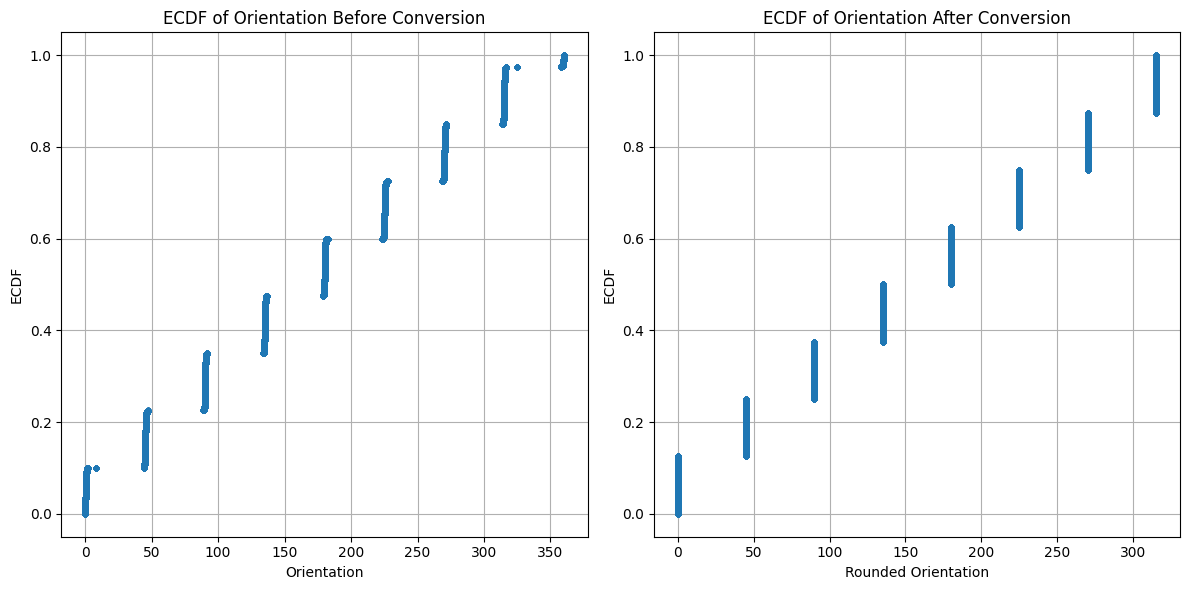

In [15]:
plotECDF1(offline_df)

In [16]:
def plotECDF2(df):
    ecdf_before = ECDF(df['orientation'])
    ecdf_after = ECDF(df['angle'])
    plt.step(ecdf_before.x, ecdf_before.y, label='Before')
    plt.step(ecdf_after.x, ecdf_after.y, label='After')
    plt.xlabel('Orientation')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Orientation')
    plt.legend()
    plt.grid(True)
    plt.show()

#plotECDF2(offline_df)

## 3. Evaluation

Für die Evaluation des Modells verwenden wir die Summe der quadrierten Fehler (SSE) als Abstandsmetrik. Der SSE misst die Gesamtabweichung der Vorhersagen des Modells von den tatsächlichen Werten, indem die Differenzen zwischen den vorhergesagten und tatsächlichen Positionen quadriert und anschließend summiert werden.

## 4. Understanding Features / Exploratory data analysis (EDA)

This section  initiates exploratory data analysis (EDA) to uncover underlying structures in the WiFi signal data. The goal is to inform downstream feature engineering and modeling strategies. In other words, to build a reliable localization model, we need to understand how signal strength behaves across different spatial and contextual conditions.

We focus on:
- **Signal distributions**: How does signal strength vary across locations, orientations, and access points?
- **Signal-distance relationship**: How does RSS decay with distance? What factors (e.g., device orientation, physical obstacles) distort this relationship?

This analysis guides feature selection, transformation strategies, and ultimately the model's predictive structure.


## Univariate analysis

We begin with a univariate statistical summary of the signal feature.
### Signal Strength Summary statistics

In [17]:
offline_df.signal.describe()
# Note that we have negative values, and the larger the values are, the stronger the signal.

count    904985.000000
mean        -59.916372
std          10.385336
min         -98.000000
25%         -67.000000
50%         -59.000000
75%         -53.000000
max         -25.000000
Name: signal, dtype: float64

Interpretation
- RSS values are inherently negative; stronger signals are numerically less negative. This asymmetry should be accounted for in e.g. signal-to-distance conversion.


### Stratifying signal strength statistics 
by both only access point (MAC address) and  including also spatial coordinates (posXY).

In [18]:
offline_df.groupby([ "mac"]).signal.agg(["median", "mean", "min", "max", "std", "count"])

,median,mean,min,max,std,count
mac,,,,,,
00:0f:a3:39:dd:cd,-71.0,-70.454794,-98,-46,8.124709,145358
00:0f:a3:39:e1:c0,-54.0,-53.701635,-92,-34,5.794879,145818
00:14:bf:3b:c7:c6,-62.0,-60.676822,-90,-38,7.080960,124535
00:14:bf:b1:97:81,-56.0,-56.347957,-87,-29,8.023517,119279
00:14:bf:b1:97:8a,-58.0,-56.644002,-90,-26,9.561987,128759
00:14:bf:b1:97:8d,-54.0,-53.764789,-93,-25,8.302156,119765
00:14:bf:b1:97:90,-69.0,-67.024261,-93,-34,10.639894,121471


some signals are high quality, low variance, others are noisier, likely further or more obstructed

In [19]:
offline_df.groupby(["posXY", "mac"]).signal.agg(["median", "mean", "min", "max", "std", "count"])

median       mean  min  max       std  count
posXY   mac                                                            
0.0-0.0 00:0f:a3:39:dd:cd   -70.0 -69.792517  -90  -61  3.789440    882
        00:0f:a3:39:e1:c0   -53.0 -53.469989  -89  -47  4.587269    883
        00:14:bf:3b:c7:c6   -66.0 -66.241335  -86  -55  3.445990    779
        00:14:bf:b1:97:81   -63.0 -64.477952  -81  -55  4.648838    703
        00:14:bf:b1:97:8a   -38.0 -38.823684  -53  -30  5.273841    760
...                           ...        ...  ...  ...       ...    ...
9.0-8.0 00:14:bf:3b:c7:c6   -53.0 -52.953083  -74  -46  3.141700    746
        00:14:bf:b1:97:81   -59.0 -59.261474  -73  -53  3.466682    719
        00:14:bf:b1:97:8a   -59.0 -58.836129  -82  -49  4.086309    775
        00:14:bf:b1:97:8d   -53.0 -53.295518  -75  -44  4.828713    714
        00:14:bf:b1:97:90   -67.0 -67.247945  -78  -58  3.624358    730

[1162 rows x 6 columns]

These distributions suggest notable variation in both central tendency and spread across access points(and locations)

We note that:
- Higher average signal strengths typically imply closer proximity or fewer obstructions.
- Variability in signal (standard deviation) might indicate reflections, interference, or unstable transmission conditions.

These insights will inform feature engineering and model assumptions.

Location-MAC profiles serve as implicit signal signatures, forming the basis for nearest-neighbor comparisons.


### Distribution of measurements:
 To ensure that out features are robust: Sufficient sampling coverage, avoiding over-representation of specific regions or directions

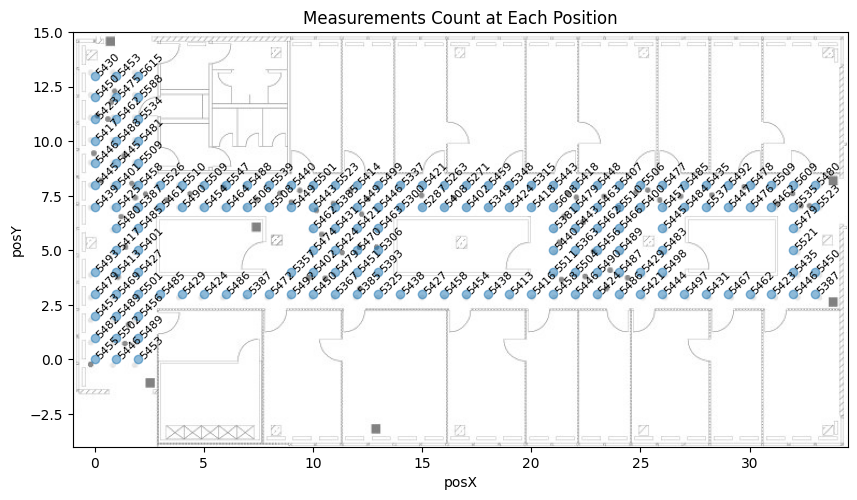

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_pil = Image.open('../img/building.jpg')
img_pil = img_pil.convert("RGB")
img_pil.save('../img/building_no_alpha.jpg')
img = mpimg.imread('../img/building_no_alpha.jpg')

grouped = offline_df.groupby(['posX', 'posY'])
locDF = [group for _, group in grouped if not group.empty]
locCounts = [(offline_df['posX'].iloc[0], offline_df['posY'].iloc[0], len(offline_df)) for offline_df in locDF]
locCountsDF = pd.DataFrame(locCounts, columns=['posX', 'posY', 'count'])

plt.figure(figsize=(10, 8))
plt.imshow(img, extent=[-1, 34.5, -4, 15], alpha=0.5, zorder=-1)


plt.scatter(locCountsDF['posX'], locCountsDF['posY'],
            alpha=0.5,
            zorder = 1)

for i, row in locCountsDF.iterrows():
    plt.annotate(int(row['count']), (row['posX'], row['posY']), size=8, rotation=45, zorder=2)

plt.xlabel('posX')
plt.ylabel('posY')
plt.title('Measurements Count at Each Position')
plt.grid(False)


plt.show()


In [21]:
locCountsDF.describe()

,posX,posY,count
count,166.000000,166.000000,166.000000
mean,14.246988,5.915663,5451.716867
std,10.598706,2.681948,57.088113
min,0.000000,0.000000,5263.000000
25%,3.000000,3.000000,5424.000000
50%,13.000000,6.500000,5454.000000
75%,23.000000,8.000000,5485.750000
max,33.000000,13.000000,5615.000000


We can see that there are between 5263 and 5615 measurements per point.

## Hypothesis-driven analysis using Visual EDA
visual exploratory data analysis (EDA): employing plots to understand the spatial and contextual distribution of signal strength (RSS).

### The effect of orientation on signal strength. 


We hypothesize that signal strength is significantly influenced by device orientation due to:
- Body occlusion effects
- directionality
- Structural elements such as walls

We begin with visual diagnostics at fixed spatial locations to validate this hypothesis. These initial results guide the selection of features for predictive modeling.

Questions:
- Is the variation in RSS consistent across all MACs?
- Does the impact of orientation diminish with distance?



Fix a location 
Boxplots and KDE plots show how signal strength varies with orientation and AP (MAC).

In [22]:
def orientation_SS_box_plot(data, x, y):
    filtered_data = data[(data['posX'] == x) & (data['posY'] == y)]

    # Define the range for the y-axis
    y_axis_range = (filtered_data['signal'].min(), filtered_data['signal'].max())

    # Create separate boxplots for each MAC address with the same y-axis scale
    plt.figure(figsize=(15, 15))
    for mac in submacs:
        mac_data = filtered_data[filtered_data['mac'] == mac]
        plt.subplot(3,3, submacs.index(mac) + 1)
        sns.boxplot(x='angle', y='signal', data=mac_data)
        plt.title(f'{mac}', fontsize=12)
        plt.xlabel('Angle (°)', fontsize=11)
        plt.ylabel('RSS [dBm]', fontsize=11)
        plt.ylim(y_axis_range)  # Set the y-axis limits

    plt.tight_layout()
    plt.show()

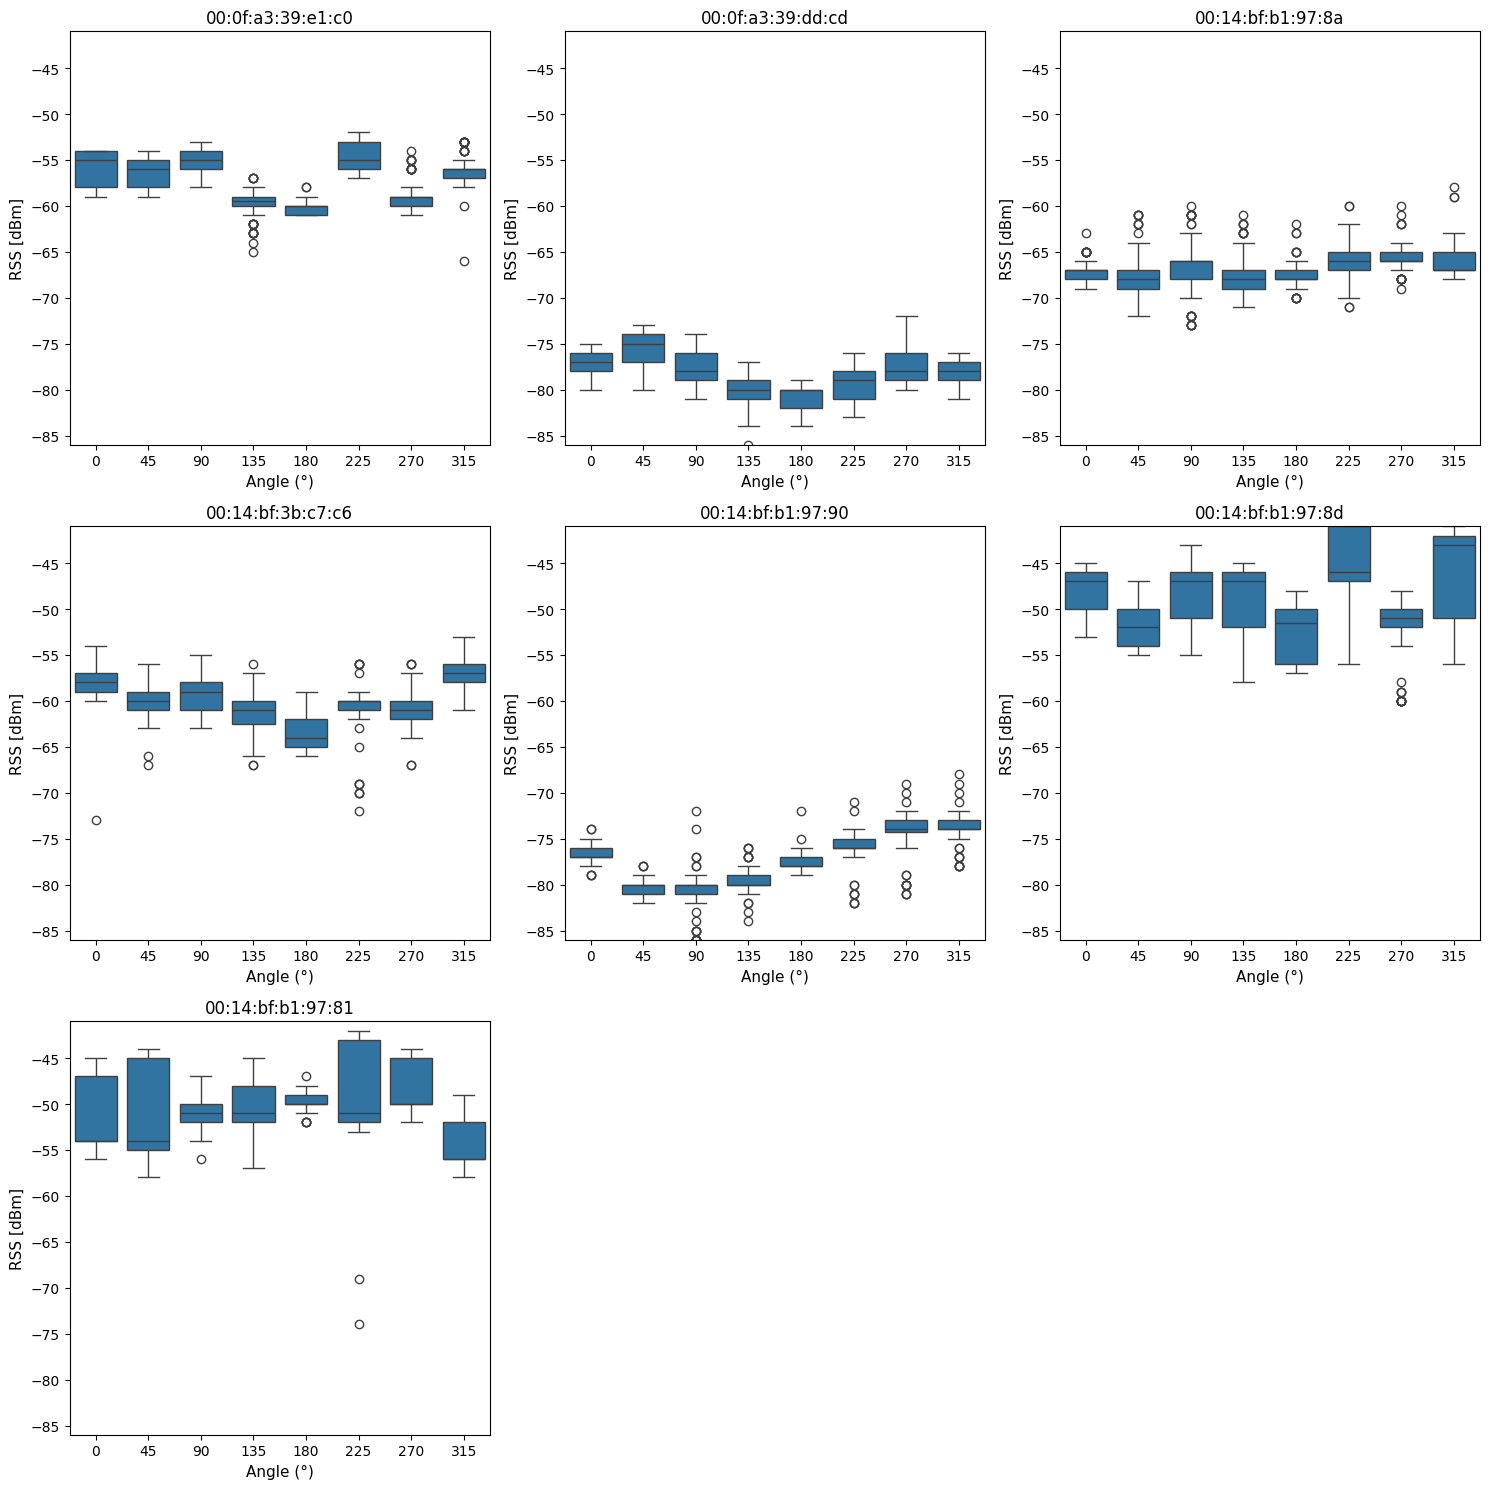

In [23]:
orientation_SS_box_plot(offline_df, 22, 5)

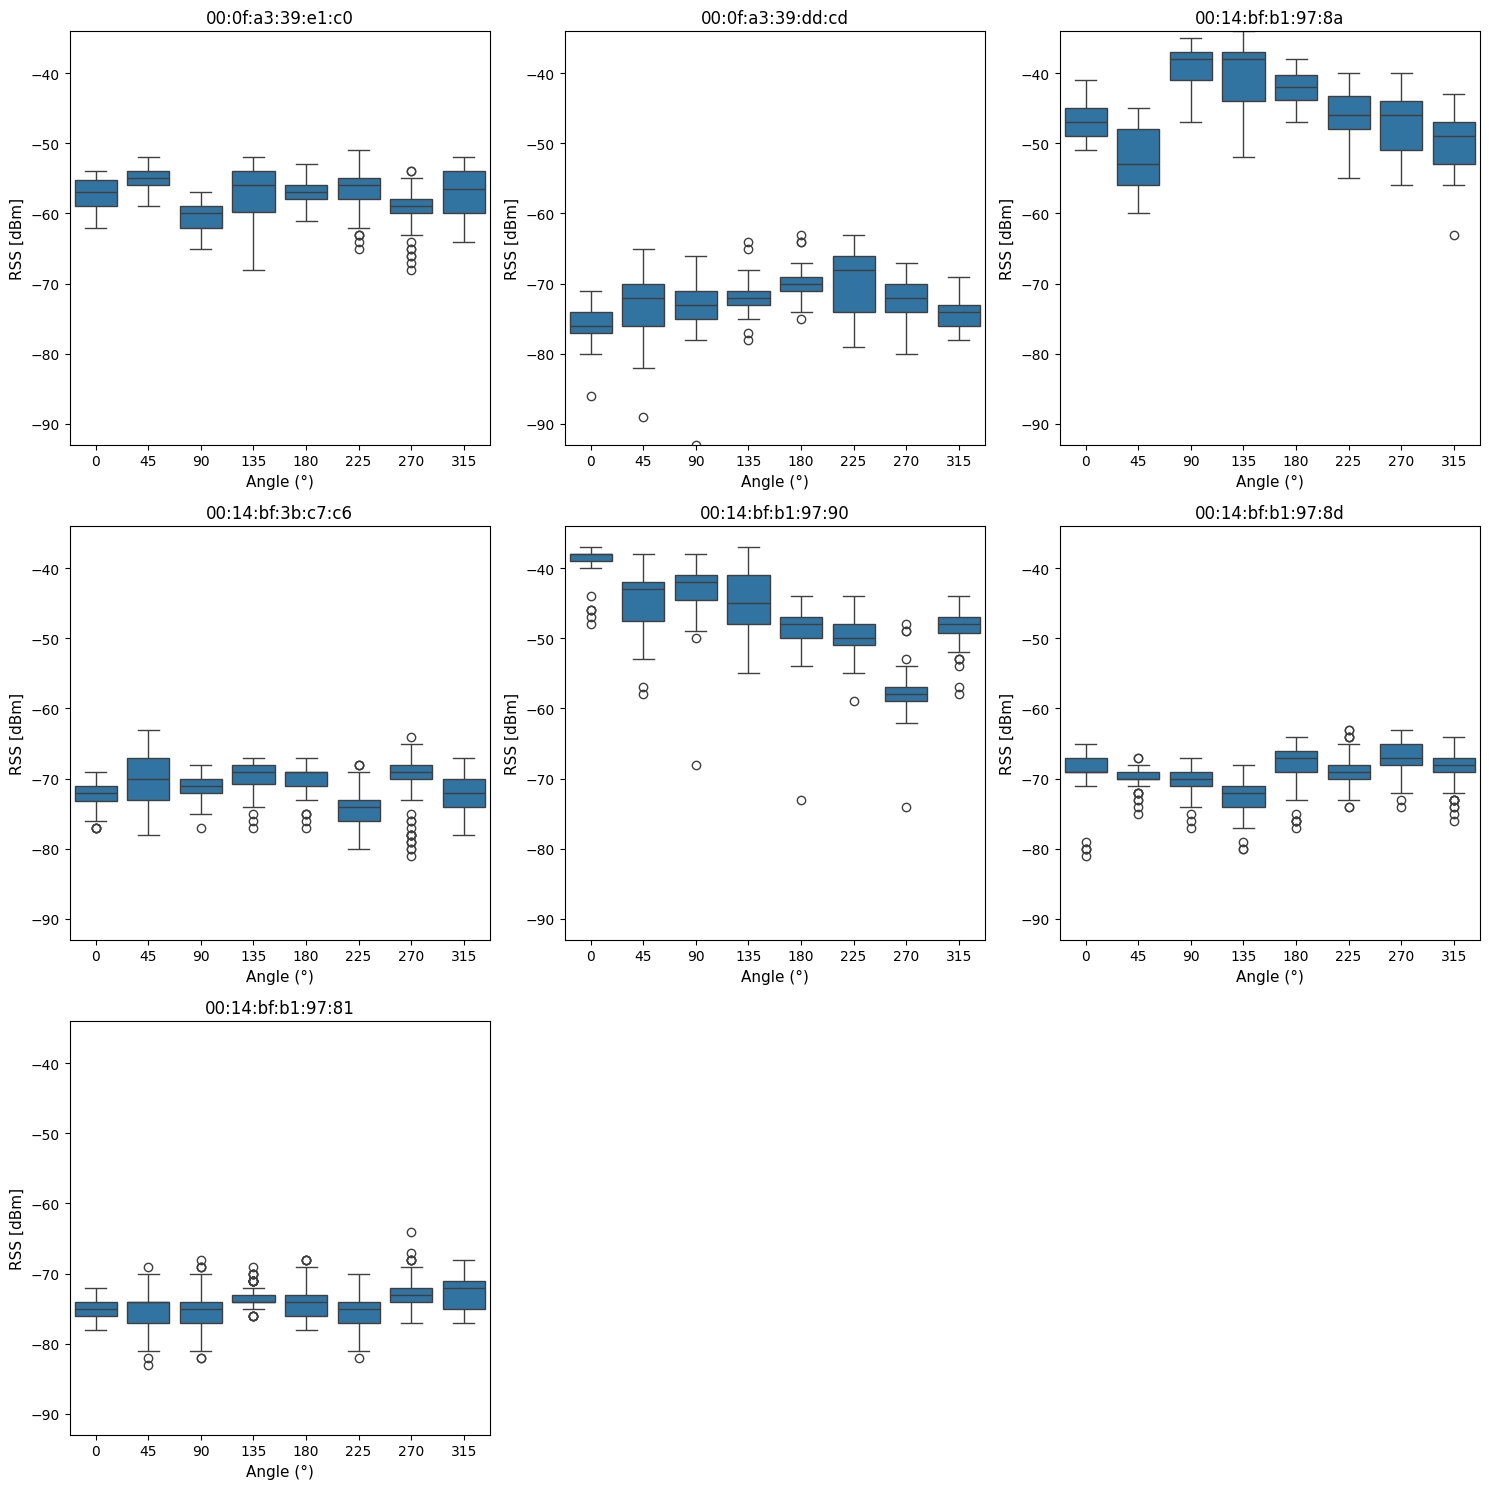

In [24]:
orientation_SS_box_plot(offline_df, 1, 13)

In [25]:
def density_plot(data, x, y):
    filtered_data = data[(data['posX'] == x) & (data['posY'] == y)]
    
    g = sns.FacetGrid(filtered_data, col='mac', row='angle', margin_titles=True, height=3, aspect=2)
    g.map_dataframe(sns.kdeplot, x='signal', bw_adjust=0.5, fill=True, cmap='coolwarm', alpha=0.7)
    
    g.set_axis_labels('Signal Strength', 'Density')
    plt.subplots_adjust(top=0.92) 
    g.fig.suptitle('Signal Density Plots by MAC Address and Angle', fontsize=16, fontweight='bold', color='navy')
    g.fig.set_size_inches(18, 12)
    g.set_titles(col_template="{col_name}", row_template="Angle: {row_name}", size=14)
    g.set_xticklabels(rotation=45, size=12)
    g.set_yticklabels(size=12)
    for ax in g.axes.flat:
        ax.set_facecolor('#f2f2f2')  
        ax.grid(True, linestyle='--', alpha=0.5)  
    g.add_legend()

    plt.show()



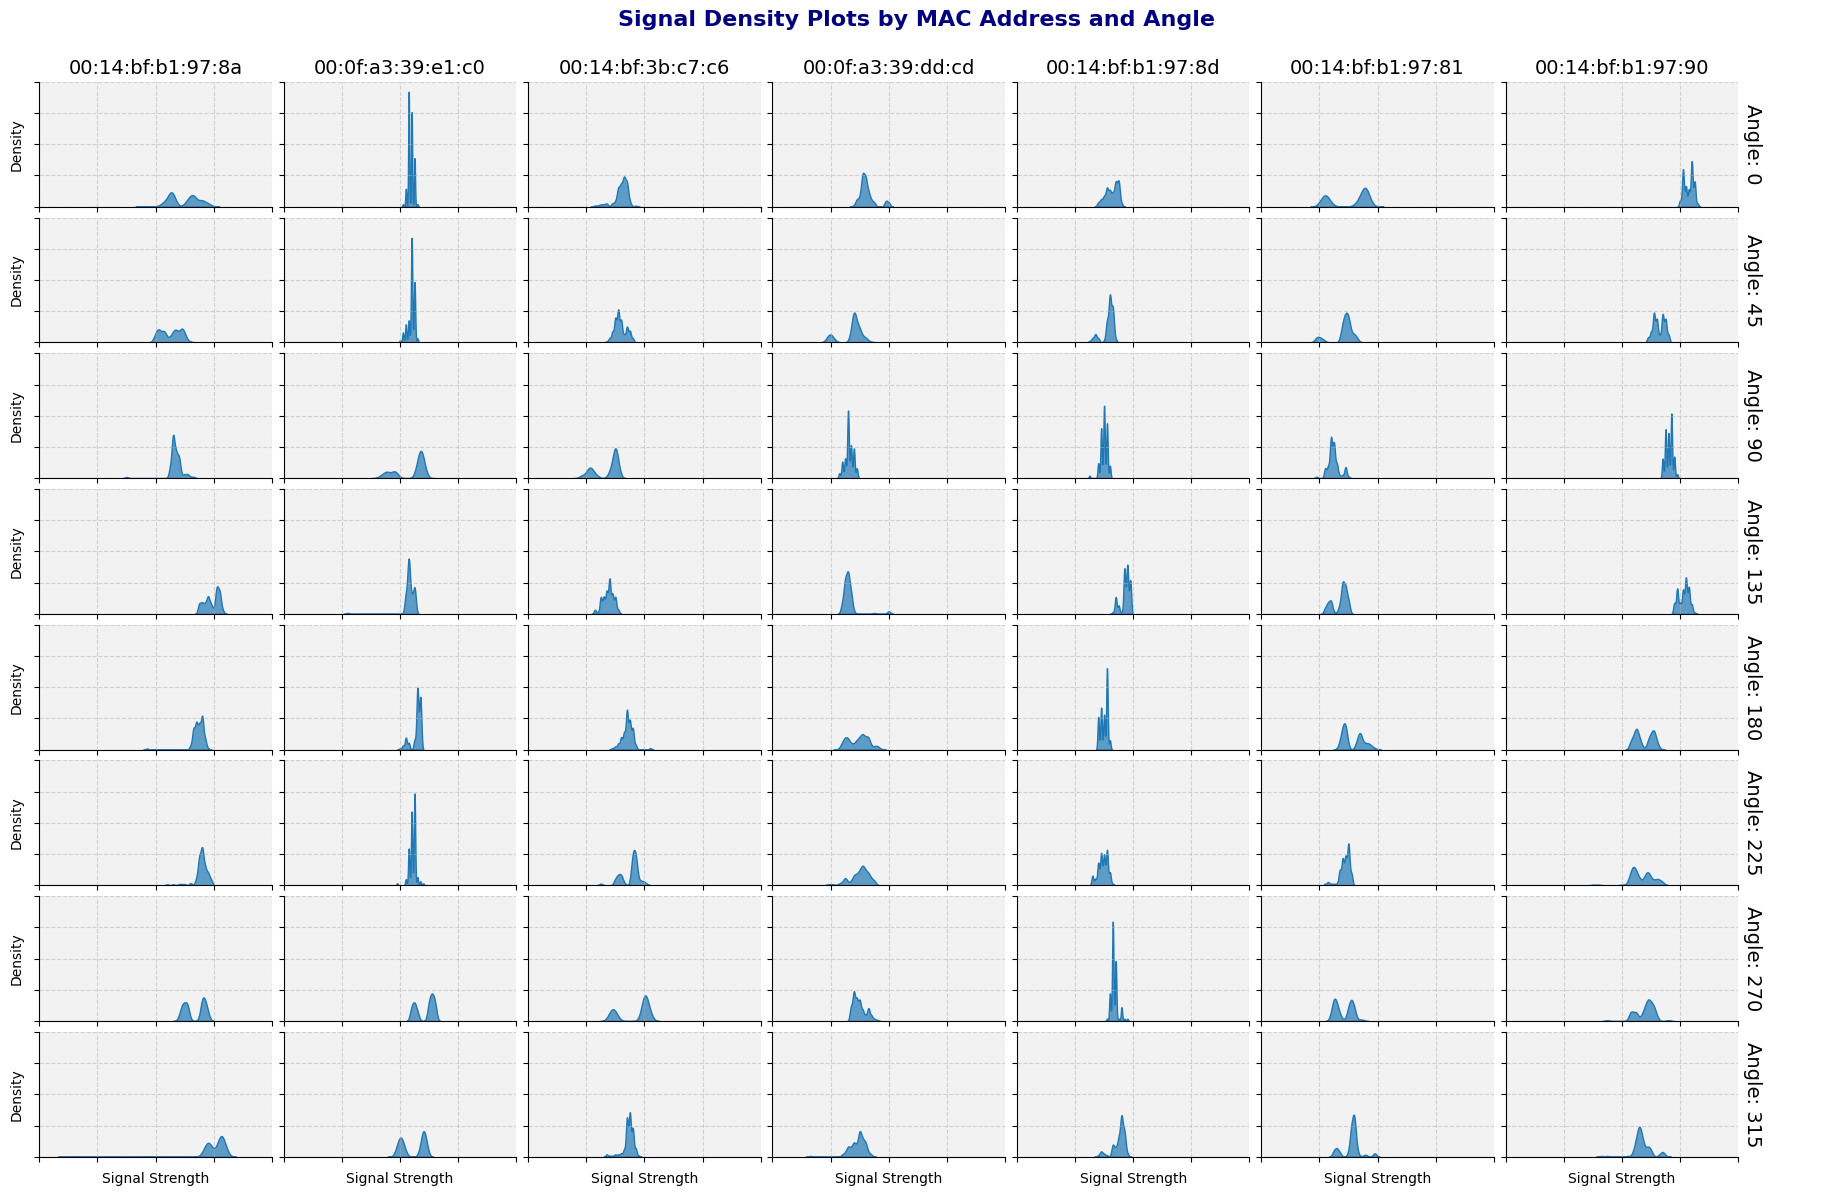

In [26]:
density_plot(offline_df, 2, 12)

In [27]:
filtered_data = offline_df[(offline_df['posX'] == 0) & (offline_df['posY'] == 0)]
filtered_data.describe()

,posX,posY,orientation,signal,angle,rawTime
count,5455.0,5455.0,5455.000000,5455.000000,5455.000000,5.455000e+03
mean,0.0,0.0,158.068433,-59.259945,157.768103,1.139643e+12
std,0.0,0.0,102.991523,10.721269,102.996365,2.456477e+05
min,0.0,0.0,0.000000,-90.000000,0.000000,1.139643e+12
25%,0.0,0.0,90.300000,-67.000000,90.000000,1.139643e+12
50%,0.0,0.0,180.300000,-62.000000,180.000000,1.139643e+12
75%,0.0,0.0,225.600000,-53.000000,225.000000,1.139644e+12
max,0.0,0.0,315.000000,-30.000000,315.000000,1.139644e+12


### Feature Engineering Kick-off:

Manually interpreting signal plots is not scalable. Instead, we summarize signal distributions using statistical descriptors. With this, we are transforming noisy, high-volume raw signal data into compact statistical summaries. 

For each combination of:
- **Location** (`posXY`)
- **Orientation** (`angle`)
- **Access Point** (`mac`)

We compute a feature vector comprising robust statistical descriptors:
- Mean
- Median
- Standard deviation
- Interquartile range (IQR)

This aggregation reduces high-volume raw signal data into structured, low-dimensional features suitable for machine learning.



In [28]:
def signal_summary(data):
    # Group the data by location (posXY), angle, and MAC address
    grouped = data.groupby(['posXY', 'angle', 'mac'])
    
    data_summary = []
    
    for name, group in grouped:
        summary = group.iloc[0]  # Take the first row of each group
        summary['medSignal'] = np.median(group['signal'])
        summary['avgSignal'] = np.mean(group['signal'])
        summary['num'] = len(group['signal'])
        summary['sdSignal'] = np.std(group['signal'])
        summary['iqrSignal'] = np.percentile(group['signal'], 75) - np.percentile(group['signal'], 25)
        data_summary.append(summary)
    
    return pd.DataFrame(data_summary)

# Compute the summary
offline_summary = signal_summary(offline_df)

offline_summary


,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal
6,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:0f:a3:39:dd:cd,-75,0,1139643118358,0.0-0.0,-67.0,-68.126126,111,3.145473,4.50
2,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,0,1139643118358,0.0-0.0,-51.0,-51.154545,110,1.402507,2.00
5,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:3b:c7:c6,-66,0,1139643118358,0.0-0.0,-67.0,-66.510870,92,1.936461,1.25
4,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,0,1139643118358,0.0-0.0,-64.0,-64.054348,92,2.601689,4.00
0,2006-02-11 07:31:58.358,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,0,1139643118358,0.0-0.0,-38.0,-39.161290,93,2.220580,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522454,2006-02-11 18:42:30.973,9.0,8.0,315.3,00:14:bf:3b:c7:c6,-54,315,1139683350973,9.0-8.0,-55.0,-54.929412,85,2.107623,4.00
522456,2006-02-11 18:42:30.973,9.0,8.0,315.3,00:14:bf:b1:97:81,-60,315,1139683350973,9.0-8.0,-61.0,-61.172414,87,3.397791,3.00
522452,2006-02-11 18:42:30.973,9.0,8.0,315.3,00:14:bf:b1:97:8a,-52,315,1139683350973,9.0-8.0,-53.0,-56.451613,93,5.393178,10.00
522455,2006-02-11 18:42:30.973,9.0,8.0,315.3,00:14:bf:b1:97:8d,-56,315,1139683350973,9.0-8.0,-61.0,-60.770115,87,2.650964,3.00


Interpretation:  no strong trend, IQR also increases
The hypothesis that closer APs exhibit higher signal variability is not strongly supported by the current summary statistics.

## Confirming our hypotheses
We begin by first look at confirming the hypotheses we formed by looking at particular examples

###  Variation in average signal strength

Look at standard deviations and see if they vary with the average signal strength.
We can use box plots, but we first need to turn avg signal into a categorical variable, by cutting it into intervals
Does the standard deviation increase or decrease with signal strength? Is it a weak or a strong trend?


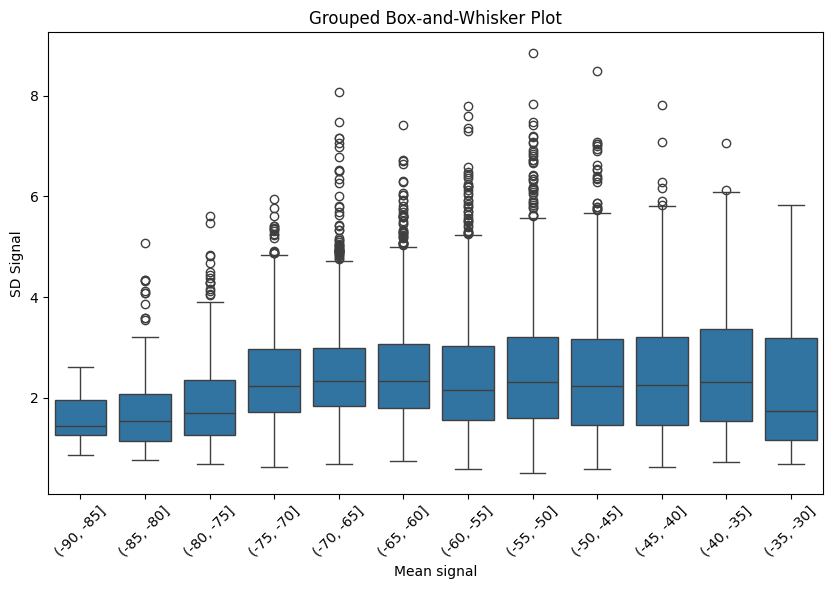

In [29]:
# Define the breaks for grouping 'avgSignal' values
breaks =   np.arange(-90, -25, 5)

# Create a new column 'cut_avgSignal' based on 'avgSignal' and the defined breaks
offline_summary['cut_avgSignal'] = pd.cut(offline_summary['avgSignal'], bins=breaks)

# Create a grouped boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cut_avgSignal', y='sdSignal', data=offline_summary)
plt.xlabel('Mean signal')
plt.ylabel('SD Signal')
plt.title('Grouped Box-and-Whisker Plot')
plt.xticks(rotation=45)

plt.show()


# Interpretation:  increase weak because IQR also increases. 

### Skewness of signal strength.
Examine the skewness of signal strength. For that, we plot the difference avg-median against the number of observations

<!-- https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html -->

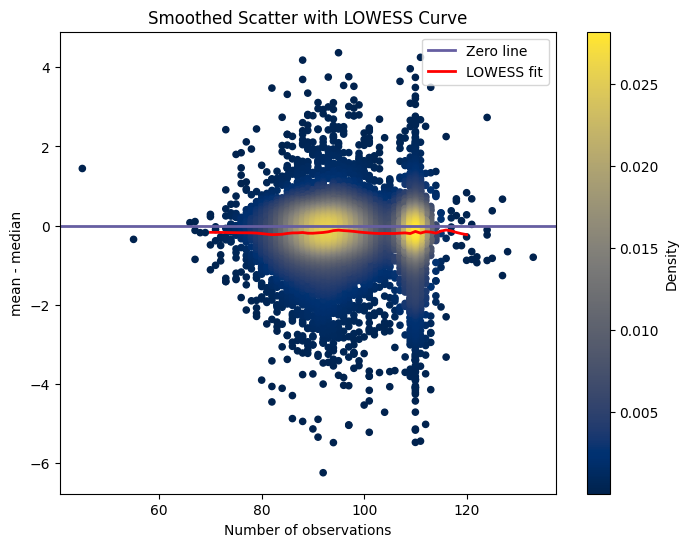

In [30]:
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate difference
offline_summary['diff'] = offline_summary['avgSignal'] - offline_summary['medSignal']

# Prepare the data
x = offline_summary['num']
y = offline_summary['diff']

# Compute a density estimate to emulate smoothScatter
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density for better visual overlap
idx = z.argsort()
x, y, z = x.iloc[idx], y.iloc[idx], z[idx]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(x, y, c=z, s=20, cmap="cividis" )
plt.colorbar(sc, label='Density')
ax.axhline(0, color="#665ea1", linewidth=2, label='Zero line')

# Apply LOWESS smoothing
lowess_result = lowess(y, x, frac=0.15)  # adjust frac for more/less smoothing

# Predict for new values (70 to 120)
x_pred = np.arange(70, 121)
lowess_interp = np.interp(x_pred, lowess_result[:, 0], lowess_result[:, 1])

# Plot the LOWESS curve
ax.plot(x_pred, lowess_interp, color='red', linewidth=2, label='LOWESS fit')

# Labels
ax.set_xlabel("Number of observations")
ax.set_ylabel("mean - median")
ax.legend()
plt.title("Smoothed Scatter with LOWESS Curve")
plt.show()


### Towards studying SSs relationship with distance

We start by trying to identify which mac address corresponds to which AP coordinates. 
We need this to be able to compute distances between the devices and the access points 

In [31]:
from scipy.interpolate import Rbf

def surface_plot(data, angle_given, mac_given, ax):

    df = data[(data['angle'] == angle_given) & (data['mac'] == mac_given)]

    if df.empty:
        ax.set_title(f"{mac_given} @ {angle_given}°\n(no data)")
        ax.axis("off")
        return

    x = df['posX'].values
    y = df['posY'].values
    z = df['avgSignal'].values

    rbf = Rbf(x, y, z, function='linear') 

    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)

    zi = rbf(xi, yi)

    c = ax.contourf(xi, yi, zi, levels=100, cmap='viridis')
    ax.set_title(f"{mac_given} @ {angle_given}°")
    ax.set_xlabel("posX")
    ax.set_ylabel("posY")
    
    plt.colorbar(c, ax=ax, fraction=0.046, pad=0.04)


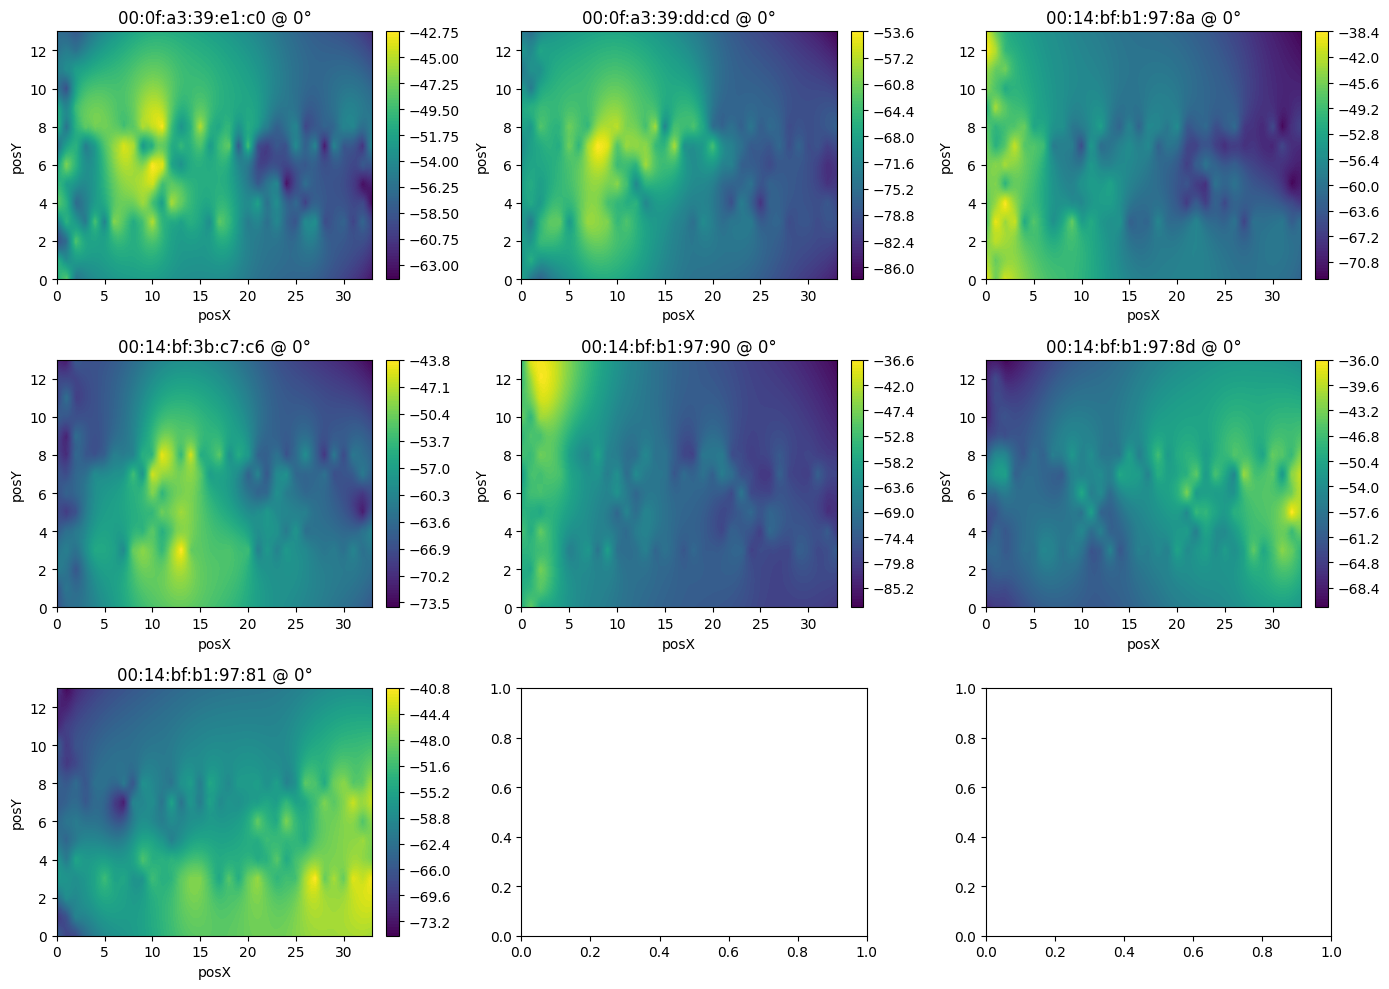

In [32]:
fig, axs = plt.subplots(3, len(submacs)//3+1, figsize=(14, 10))
axs = axs.flatten()  # Flatten in case of 2D array of axes

macs = [submacs[i] for i in range(len(submacs))]
angles = [0]*len(submacs)

for i, (mac, angle) in enumerate(zip(macs, angles)):
    mesh = surface_plot(offline_summary, angle, mac, axs[i])

plt.tight_layout()
plt.show()

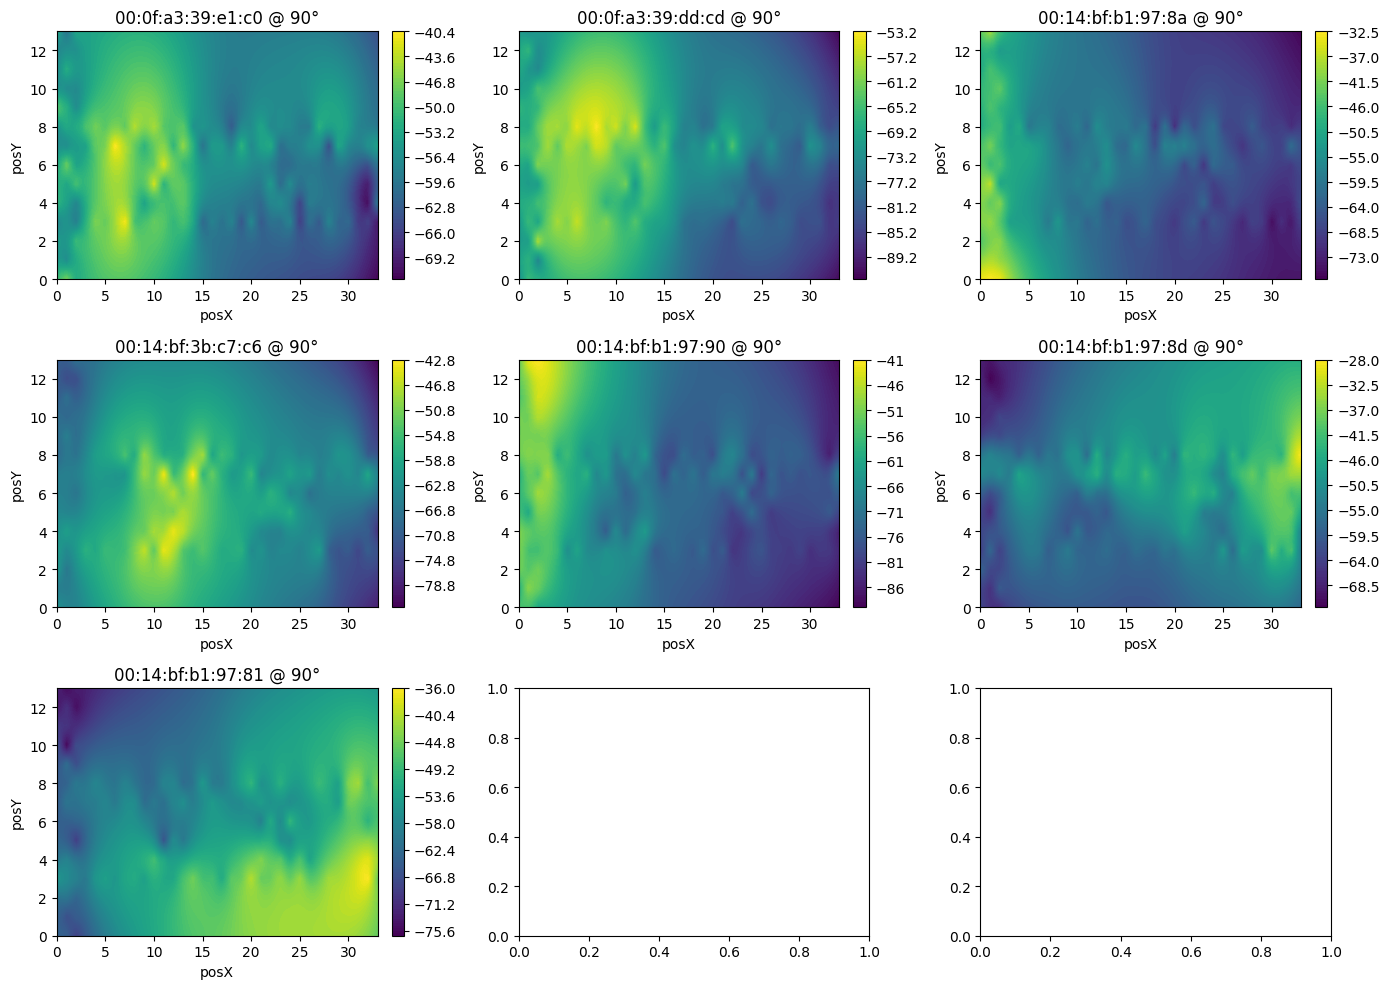

In [33]:
fig, axs = plt.subplots(3, len(submacs)//3+1, figsize=(14, 10))
axs = axs.flatten()  # Flatten in case of 2D array of axes

macs = [submacs[i] for i in range(len(submacs))]
angles = [90]*len(submacs)

for i, (mac, angle) in enumerate(zip(macs, angles)):
    mesh = surface_plot(offline_summary, angle, mac, axs[i])

plt.tight_layout()
plt.show()

#### The corridor effect

From the above plots we see the effect of orientation on signal strength and we can identify a corridor effect: Signal propagation is better along corridors.
Modelling this effect might improve the result

#### The 6 AP's and their locations 

In [34]:
submacs= ['00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d',
       '00:14:bf:b1:97:81']
submacs.remove(submacs[1])

offlineSummary_without_cd = offline_summary[offline_summary['mac']!= '00:0f:a3:39:dd:cd']
offlineSummary_without_c0 = offline_summary[offline_summary['mac']!= '00:0f:a3:39:e1:c0']

In [35]:
submacs

['00:0f:a3:39:e1:c0',
 '00:14:bf:b1:97:8a',
 '00:14:bf:3b:c7:c6',
 '00:14:bf:b1:97:90',
 '00:14:bf:b1:97:8d',
 '00:14:bf:b1:97:81']

In [36]:
# Define the AP matrix
AP = pd.DataFrame({
    "x": [7.5, 2.5, 12.8, 1, 33.5, 33.5],
    "y": [6.3, -0.8, -2.8, 14, 9.3, 2.8]
}, index=submacs)
AP

,x,y
00:0f:a3:39:e1:c0,7.5,6.3
00:14:bf:b1:97:8a,2.5,-0.8
00:14:bf:3b:c7:c6,12.8,-2.8
00:14:bf:b1:97:90,1.0,14.0
00:14:bf:b1:97:8d,33.5,9.3
00:14:bf:b1:97:81,33.5,2.8


In [37]:
def add_distance_column(df, ap_positions):
    df = df.copy()

    def compute_distance(row):
        try:
            ap = ap_positions.loc[row['mac']]
            dx = row['posX'] - ap['x']
            dy = row['posY'] - ap['y']
            return np.sqrt(dx**2 + dy**2)
        except KeyError:
            return np.nan  # Falls MAC nicht im AP-Index vorhanden ist

    df['distance'] = df.apply(compute_distance, axis=1)
    return df

offlineSummary = add_distance_column(offlineSummary_without_cd, AP)


In [38]:
def plot_signal_vs_distance(data, angle_filter):

    df = data[data['angle'] == angle_filter]

    macs = df['mac'].unique()
    n_macs = len(macs)

    cols = 8 
    rows = (n_macs + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(cols*2.5, rows*3), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, mac in enumerate(macs):
        subset = df[df['mac'] == mac]
        axs[i].scatter(subset['distance'], subset['signal'], s=10)
        axs[i].set_title(f"mac: {mac}", fontsize=8)
        axs[i].set_xlabel("distance")
        axs[i].set_ylabel("signal")
    
    for j in range(i+1, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"Signal vs. Distance bei angle: {angle_filter}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


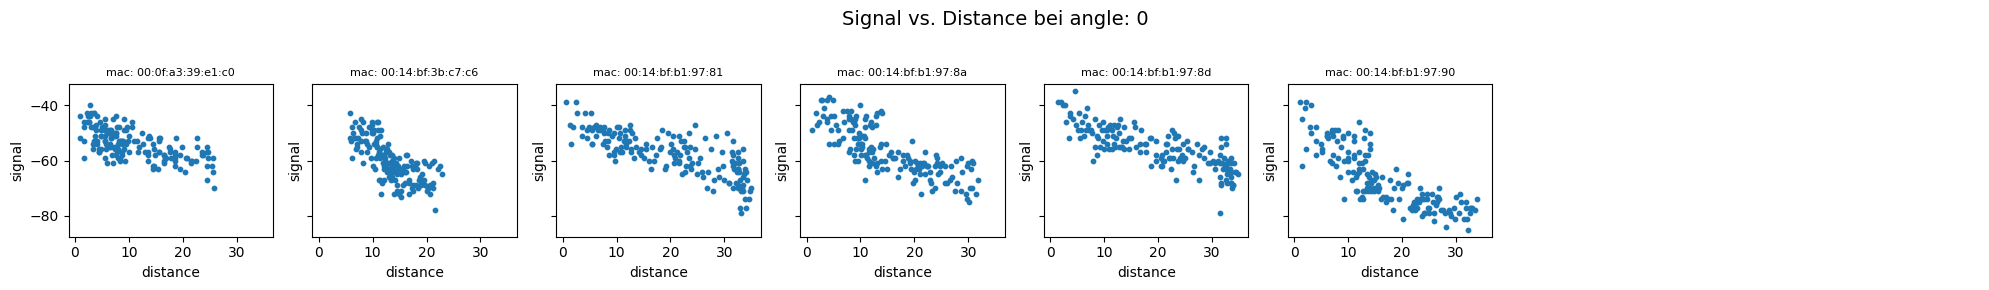

In [39]:
plot_signal_vs_distance(offlineSummary, angle_filter = 0)

## 5. Models

### K-NN, what do we need?

We want to predict the location of a new point based on how similar the signals from the 6 AP are. As we mentioned already, since the orientation impacts signal, we will subset the data and select only recordings with same/similar orientations

- we choose k neighbours, by calculating the similarity between the vectors of 6 values.
- what kind of similarity can we use? 
    - Euclidian Distance (L2 Norm)
    - Dot product
    - Cosine Similarity
    - Manhattan Distance (L1 Norm)
    - Minkowski Distance (Lp Norm)
    - ...
Please reflect what these metrics measure and when to use them.

Are all access points of equal importance or should we distinguish between close and far access points? 

Which other features can we consider and how can we include them in the analysis?
- We already argued that  orientation impacts the recorded signals and hence taking a subset of the data makes sense.

## Modeling baseline: k-NN

- is a simple approach, to set the benchmark
- We naturally think of measuring the distance between two sets of signal strengths with Euclidean distance, i.e. we compare vectors of size 6

 $\sqrt{(\sum (s_i^*-s_i)^2)}$, where 
 - $s_i$ is the signal strength measured between the hand-held device and the i-th access point for a training observation taken at some specified location, and
 - $s^*_i$ is the signal measured between the same access point and our new point whose (x, y) values we are trying to predict.


- Read about K-NN
    - non-parametric, classification or regression.
    - training: just storing the offline data
    - new point = a new set of signal strengths for a location that is not known, 
    - we find the k observations in our training data that is closest to this new observation and 
    - we estimate the new observation's position by an aggregation of the positions of the k training points (e.g. mean or weighted mean)

Downside 

   - We assume similarity of the new data to the offline data
   - Hence we can only consider known AP's and we would need new measurements if anything changes

## Preparing and Analyzing the online data set


In [40]:
online = read_data("online.final.trace.txt") 
online['mac'].unique()

array(['00:14:bf:b1:97:8a', '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6',
       '00:14:bf:b1:97:81', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90',
       '00:0f:a3:39:dd:cd'], dtype=object)

In [41]:
online.head(5)

,time,posX,posY,orientation,mac,signal,angle,rawTime,posXY
0,2006-02-11 21:14:37.303,0.0,0.05,130.5,00:14:bf:b1:97:8a,-43,135,1139692477303,0.0-0.05
1,2006-02-11 21:14:37.303,0.0,0.05,130.5,00:0f:a3:39:e1:c0,-52,135,1139692477303,0.0-0.05
2,2006-02-11 21:14:37.303,0.0,0.05,130.5,00:14:bf:3b:c7:c6,-62,135,1139692477303,0.0-0.05
3,2006-02-11 21:14:37.303,0.0,0.05,130.5,00:14:bf:b1:97:81,-58,135,1139692477303,0.0-0.05
4,2006-02-11 21:14:37.303,0.0,0.05,130.5,00:14:bf:b1:97:8d,-62,135,1139692477303,0.0-0.05


### Number of new measurements

In [42]:
online['posXY'].nunique()

60


### The Distribution of new signals

Look at how the 60 new recorded signals are distributed in location and angle.

In [43]:
angle_per_location = pd.crosstab(index=online['posXY'], columns=online['angle'])
angle_per_location.head()

angle,0,45,90,135,180,225,270,315
posXY,,,,,,,,
0.0-0.05,0,0,0,704,0,0,0,0
0.15-9.42,0,0,717,0,0,0,0,0
0.31-11.09,0,0,0,0,0,684,0,0
0.47-8.2,701,0,0,0,0,0,0,0
0.78-10.94,695,0,0,0,0,0,0,0


### Bringing the online data in a form suitable for prediction

When we consider similarity between two measurements we will look at a vector of 6 SS values for each of the measurements, and we calculate the distance between these.

We hence reorganize the data to have one column representing each of the 6 APs, and the values will be the average signal strength measured for that AP at each location. The measurements are repeated to ensure that the noise affects the values less (regression to the mean)

In [44]:

selected_columns = ["posXY", "posX", "posY", "orientation", "angle", "mac", "signal"]
online = online[selected_columns]
onlineSummary = online.pivot_table(index=["posXY", "posX", "posY", "angle"],
                                   columns="mac",
                                   values="signal",
                                   aggfunc="mean")

onlineSummary.reset_index(inplace=True)


onlineSummary_withoutMac_cd = onlineSummary.drop(['00:0f:a3:39:dd:cd'], axis=1)
onlineSummary_withoutMac_c0 = onlineSummary.drop(['00:0f:a3:39:e1:c0'], axis=1)

onlineSummary_withoutMac_c0.head()

mac,posXY,posX,posY,angle,00:0f:a3:39:dd:cd,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0.0-0.05,0.00,0.05,135,-63.207207,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15,9.42,90,-66.117117,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31,11.09,225,-67.054054,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47,8.20,0,-74.153153,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78,10.94,0,-71.403670,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


## Selecting m similar angles

We saw that we have only **one orientation** for each location.



For each new point, we want to find records in our offline data set, that have similar to our new observation. Since we saw that orientation impacts the signal, we should choose records with similar orientations. We could use records with an orientation that is within a specified range of the new point's orientation, i.e. m, the number of neighboring angles. This will be a parameter for our model as well, along with k, the number of neighboring points.

In [45]:
def nearest_angles(angle_obs, m):
    predefined_angles = list(range(0, 360, 45))
    differences = [abs(a - angle_obs) for a in predefined_angles]
    nearest = sorted(zip(differences, predefined_angles))[:m]
    nearest_angles = sorted([angle for _, angle in nearest])
    
    return nearest_angles


m = 3
angle_new_obs = 230
angles = nearest_angles(angle_new_obs, m)
print(angles)

[180, 225, 270]


### Subsetting the data
We will subset the data to only consider neighbouring angles and we aggregate the signal strengths from the angles and create a data structure that is similar to onlineSummary, containing the avg signals from the 6 AP.

In [46]:
def reshape_SS(data, var_signal='avgSignal', keep_vars=['posXY', 'posX', 'posY']):
    submacs= ['00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d',
       '00:14:bf:b1:97:81']
    
    unique_posXY = data['posXY'].unique()
    reshaped_data = pd.DataFrame({'posXY': unique_posXY,
                                  'posX': [float(xy.split('-')[0]) for xy in unique_posXY], 
                                 'posY': [float(xy.split('-')[1]) for xy in unique_posXY]})
    for mac in submacs:
        
        avg_signal = data[data['mac'] == mac].groupby('posXY')[var_signal].mean().reset_index()
        avg_signal.rename(columns={var_signal: f"{mac}"}, inplace=True)
        reshaped_data = reshaped_data.merge(avg_signal, on='posXY', how='left')
    reshaped_data = reshaped_data.dropna(axis=1, how='all')

    return reshaped_data

In [47]:
offline_subset = offlineSummary_without_c0[offlineSummary_without_c0['angle'].isin(angles)]
trainSS = reshape_SS(offline_subset, var_signal='avgSignal')
trainSS

,posXY,posX,posY,00:0f:a3:39:dd:cd,00:14:bf:b1:97:8a,00:14:bf:3b:c7:c6,00:14:bf:b1:97:90,00:14:bf:b1:97:8d,00:14:bf:b1:97:81
0,0.0-0.0,0.0,0.0,-69.839610,-36.270354,-67.039305,-56.186351,-65.500256,-64.833865
1,0.0-1.0,0.0,1.0,-70.869697,-38.219141,-64.662538,-57.057283,-67.035534,-65.322619
2,0.0-10.0,0.0,10.0,-67.979569,-44.928816,-63.587393,-53.354363,-66.241311,-67.644029
3,0.0-11.0,0.0,11.0,-70.706061,-48.637281,-65.347747,-54.977484,-66.745612,-65.592623
4,0.0-12.0,0.0,12.0,-68.951855,-43.766931,-67.041814,-53.610353,-70.981056,-69.825718
...,...,...,...,...,...,...,...,...,...
161,8.0-8.0,8.0,8.0,-57.543462,-59.197690,-54.950697,-64.283506,-51.513167,-60.106836
162,9.0-3.0,9.0,3.0,-63.477954,-52.438116,-51.291078,-65.774335,-57.636806,-56.925672
163,9.0-4.0,9.0,4.0,-60.346948,-54.156565,-51.798508,-67.764247,-56.611115,-54.747774
164,9.0-7.0,9.0,7.0,-55.338462,-60.687104,-51.456782,-64.947490,-53.615612,-59.753720


In [48]:
def selectTrain(angle_new_obs, signals = None, m = 1):
    
    angles = nearest_angles(angle_new_obs, m)
    offline_subset = signals[signals['angle'].isin(angles)]
    
    return reshape_SS(offline_subset, var_signal="avgSignal")

train130 = selectTrain(130, offline_summary, m=3)
train130

,posXY,posX,posY,00:0f:a3:39:e1:c0,00:0f:a3:39:dd:cd,00:14:bf:b1:97:8a,00:14:bf:3b:c7:c6,00:14:bf:b1:97:90,00:14:bf:b1:97:8d,00:14:bf:b1:97:81
0,0.0-0.0,0.0,0.0,-52.376905,-71.763525,-35.605925,-66.122311,-55.330931,-64.232100,-63.180830
1,0.0-1.0,0.0,1.0,-52.981818,-70.473746,-39.385969,-65.386545,-59.164227,-65.448672,-63.729407
2,0.0-10.0,0.0,10.0,-56.341840,-70.129457,-44.702913,-65.677888,-50.432784,-66.853498,-69.148803
3,0.0-11.0,0.0,11.0,-54.734195,-70.626044,-48.370738,-67.140381,-54.924504,-66.787793,-70.298081
4,0.0-12.0,0.0,12.0,-56.030303,-68.848401,-45.177448,-70.433034,-50.498863,-66.722346,-72.264298
...,...,...,...,...,...,...,...,...,...,...
161,8.0-8.0,8.0,8.0,-47.677843,-57.078433,-59.599072,-57.236322,-63.589786,-52.068295,-59.455546
162,9.0-3.0,9.0,3.0,-50.803030,-62.054508,-56.438280,-49.253014,-64.203939,-55.610276,-51.721920
163,9.0-4.0,9.0,4.0,-49.307321,-63.942877,-56.582362,-51.674096,-68.334386,-58.640586,-52.787892
164,9.0-7.0,9.0,7.0,-49.009091,-58.956286,-58.712906,-50.578452,-68.975054,-52.869791,-61.903351


In [ ]:
def find_nn(new_signal, train_subset):
    diffs = train_subset.iloc[:, 3:9].apply(lambda x: x - new_signal, axis=1)
    dists = np.sqrt((diffs**2).sum(axis=1))
    closest = dists.sort_values().index
    return train_subset.loc[closest, ['posX', 'posY']]
def pred_xy(new_signals, new_angles, train_data, num_angles=1, k=3):
    est_xy = []
    for i in range(len(new_signals)):
        train_ss = selectTrain(new_angles[i], train_data, m=num_angles)
        #train_ss = selectTrain(new_angles.iloc[i], train_data, m=num_angles)

        close_xy = find_nn(new_signal=new_signals.iloc[i, :], train_subset=train_ss)
        est_xy.append(close_xy.iloc[:k, :].mean())
    return pd.DataFrame(est_xy)#, columns=['predX', 'predY'])
def find_nn_weighted(new_signal, train_subset, k=3, epsilon=1e-5):
    diffs = train_subset.iloc[:, 3:9].apply(lambda x: x - new_signal, axis=1)
    dists = np.sqrt((diffs**2).sum(axis=1))
    
    nearest_idx = dists.nsmallest(k).index
    nearest_dists = dists.loc[nearest_idx]
    nearest_positions = train_subset.loc[nearest_idx, ['posX', 'posY']]
    
    weights = 1 / (nearest_dists + epsilon)
    weights = weights / weights.sum()
    
    weighted_pos = (nearest_positions.T * weights).T
    return weighted_pos.sum()

In [50]:
def pred_xy(new_signals, new_angles, train_data, num_angles=1, k=3):
    est_xy = []
    for i in range(len(new_signals)):
        train_ss = selectTrain(new_angles[i], train_data, m=num_angles)
        #train_ss = selectTrain(new_angles.iloc[i], train_data, m=num_angles)

        close_xy = find_nn(new_signal=new_signals.iloc[i, :], train_subset=train_ss)
        est_xy.append(close_xy.iloc[:k, :].mean())
    return pd.DataFrame(est_xy)#, columns=['predX', 'predY'])

def pred_xy_weighted(new_signals, new_angles, train_data, num_angles=1, k=3):
    est_xy = []

    for i in range(len(new_signals)):
        train_ss = selectTrain(new_angles[i], train_data, m=num_angles)
        pred = find_nn_weighted(new_signal=new_signals.iloc[i, :], train_subset=train_ss, k=k)
        est_xy.append(pred)

    return pd.DataFrame(est_xy)


In [51]:
def plot_estimates(train, test, est_var, title='Estimated vs. Actual Positions'):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(train['posX'], train['posY'], color="blue", s=1, label='Training positions')
    ax.scatter(test['posX'], test['posY'], color='green', s=10, label='True positions')
    ax.scatter(est_var.iloc[:, 0], est_var.iloc[:, 1], color='red', s=10, label='Estimated positions')

    # Draw lines between true and estimated positions
    for i in range(len(est_var)):
        x_coords = [test.iloc[i]['posX'], est_var.iloc[i, 0]]
        y_coords = [test.iloc[i]['posY'], est_var.iloc[i, 1]]
        ax.plot(x_coords, y_coords, color='red', alpha=0.3, linewidth=0.8)

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


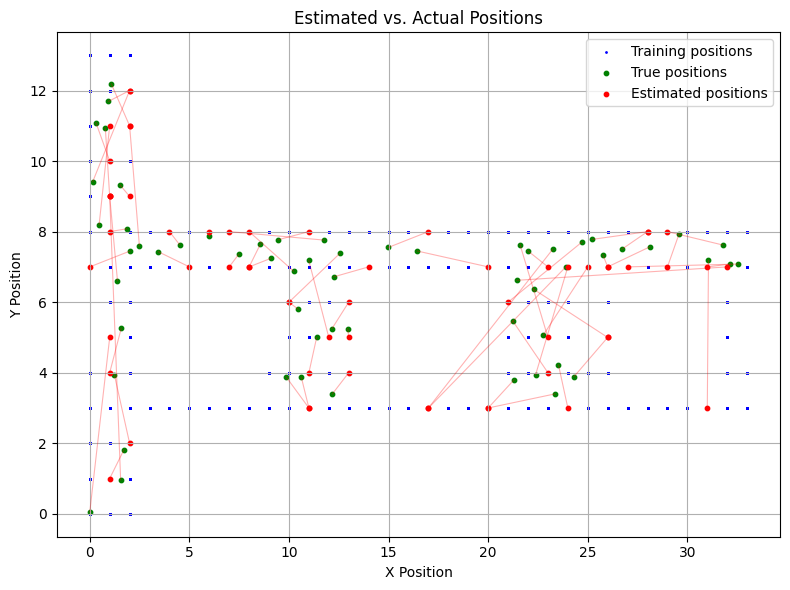

In [52]:
est_xy_k1 = pred_xy(new_signals = onlineSummary_withoutMac_cd.iloc[:, 4:], 
                    new_angles = onlineSummary_withoutMac_cd.iloc[:, 3], 
                    train_data = offlineSummary_without_cd, num_angles=3, k=1)
plot_estimates(offlineSummary_without_cd, onlineSummary_withoutMac_cd, est_xy_k1)

In [78]:
def evaluate_position_error(est_xy, actual_xy):
    est = np.asarray(est_xy)[:, :2]
    actual = np.asarray(actual_xy)[:, :2]
    
    squared_diffs = np.sum((est - actual) ** 2, axis=1)
    
    sse = np.sum(squared_diffs)
    mse = np.mean(squared_diffs)
    rmse = np.sqrt(mse)
    
    return {"SSE": sse, "MSE": mse, "RMSE": rmse}

evaluate_position_error(est_xy_k1, onlineSummary_withoutMac_cd.iloc[:, 1:3])

{'SSE': np.float64(621.4202999999999),
 'MSE': np.float64(10.357004999999997),
 'RMSE': np.float64(3.2182301036439265)}

Lets see what are the best k and m values

### Parameter selection and cross validation

The question of which value for k is the best, still remains, as well as the choce of m, the number of angles to condider.

Ideally, we want to choose the value of k independent of our test data so that we do not overfit our model to the training data. 

The method of v-fold cross-validation can help us do this:

we divide our training data into v non-overlapping subsets of equal size.

for each subset, we build models with the data that are not in that subset

and we assess the predictive ability of the model using the subset that was left out

We repeat this model fitting and assessment for each of the v folds and aggregate the prediction errors across the folds.

Recall that we have 166 locations, each with 8 orientations and measurements from 6 AP. We want to select one orientation at random for each location. 


In [ ]:
from sklearn.model_selection import GroupKFold


k_values = [1, 3, 5, 7, 9, 11]
m_values = [1, 3, 5]

best_error = float('inf')
best_k = None
best_m = None
results = []

gkf = GroupKFold(n_splits=11)
groups = offlineSummary_without_c0["posXY"]

for k_val in k_values:
    for m_val in m_values:
        print(f"Teste k={k_val}, m={m_val}")
        fold_errors = []

        for i, (train_idx, test_idx) in enumerate(gkf.split(offlineSummary_without_c0, groups=groups)):
            train_data = offlineSummary_without_c0.iloc[train_idx]
            test_data = offlineSummary_without_c0.iloc[test_idx]

            selected_columns = ["posXY", "posX", "posY", "orientation", "angle", "mac", "signal"]
            test_data = test_data[selected_columns]
            test_data_sum = test_data.pivot_table(index=["posXY", "posX", "posY", "angle"],
                                                  columns="mac",
                                                  values="signal",
                                                  aggfunc="mean").reset_index()
            

            test_signals = test_data_sum.iloc[:, 4:]
            test_angles = test_data_sum["angle"]
            true_positions = test_data_sum[["posX", "posY"]].reset_index(drop=True)

            pred_positions = pred_xy(
                new_signals=test_signals,
                new_angles=test_angles,
                train_data=train_data,
                num_angles=m_val,
                k=k_val
            ).reset_index(drop=True)

            diff = true_positions - pred_positions
            dist_error = np.sqrt((diff ** 2).sum(axis=1))
            fold_error = dist_error.mean()
            fold_errors.append(fold_error)

            #print(f"  Fold {i+1}: Fehler = {fold_error:.2f} m")

        mean_error = np.mean(fold_errors)
        std_error = np.std(fold_errors)
        results.append((k_val, m_val, mean_error, std_error))

        if mean_error < best_error:
            best_error = mean_error
            best_k = k_val
            best_m = m_val

# Ergebnisübersicht
print("\nAlle getesteten Kombinationen:")
for k, m, err, std in results:
    print(f"k={k}, m={m} → Fehler: {err:.2f} ± {std:.2f} m")

print(f"Beste Parameterkombination: k={best_k}, m={best_m} mit Fehler {best_error:.2f} m")


Teste k=1, m=1
Teste k=1, m=3
Teste k=1, m=5
Teste k=3, m=1
Teste k=3, m=3
Teste k=3, m=5

Alle getesteten Kombinationen:
k=1, m=1 → Fehler: 3.21 ± 0.21 m
k=1, m=3 → Fehler: 3.00 ± 0.13 m
k=1, m=5 → Fehler: 2.95 ± 0.13 m
k=3, m=1 → Fehler: 2.72 ± 0.19 m
k=3, m=3 → Fehler: 2.60 ± 0.16 m
k=3, m=5 → Fehler: 2.64 ± 0.14 m

✅ Beste Parameterkombination: k=3, m=3 mit Fehler 2.60 m


Beste Parameterkombination: k=5, m=3 mit Fehler 2.50 m

Lets test this with KNN and weighted KNN

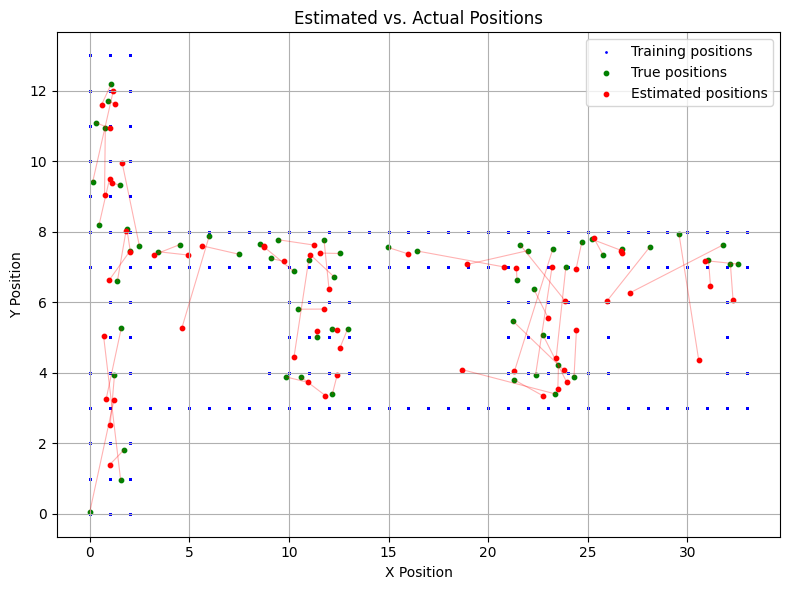

{'SSE': np.float64(264.4284781147711),
 'MSE': np.float64(4.407141301912852),
 'RMSE': np.float64(2.0993192472591806)}

In [55]:

est_xy_weighted_k5 = pred_xy_weighted(
    new_signals = onlineSummary_withoutMac_c0.iloc[:, 4:], 
    new_angles = onlineSummary_withoutMac_c0.iloc[:, 3], 
    train_data = offlineSummary_without_c0, 
    num_angles = 3, 
    k = 5
)

plot_estimates(offlineSummary_without_cd, onlineSummary_withoutMac_c0, est_xy_weighted_k5)
evaluate_position_error(est_xy_weighted_k5, onlineSummary.iloc[:, 1:3])


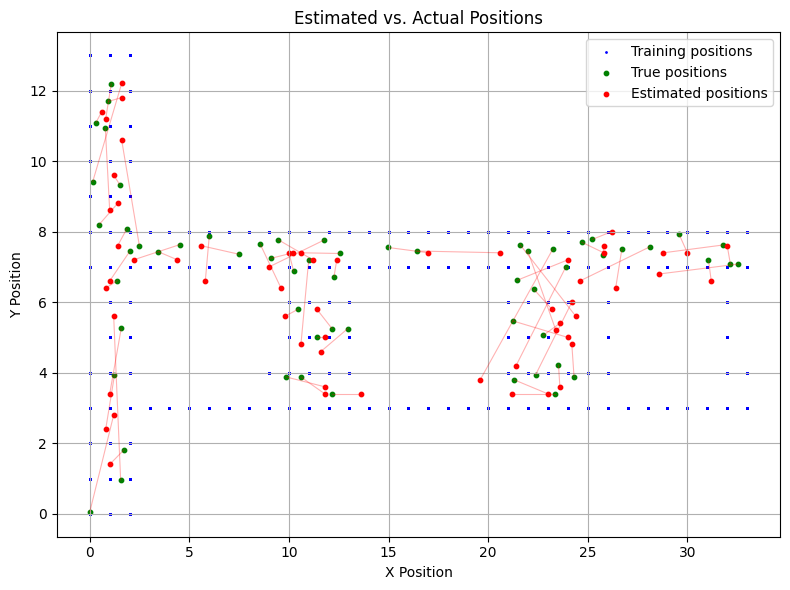

{'SSE': np.float64(274.5522999999999),
 'MSE': np.float64(4.575871666666665),
 'RMSE': np.float64(2.1391287167131074)}

In [56]:
est_xy_k5 = pred_xy(new_signals = onlineSummary_withoutMac_cd.iloc[:, 4:], 
                    new_angles = onlineSummary_withoutMac_cd.iloc[:, 3], 
                    train_data = offlineSummary_without_cd, num_angles=3, k=5)
plot_estimates(offlineSummary_without_cd, onlineSummary_withoutMac_cd, est_xy_k5)
evaluate_position_error(est_xy_k5, onlineSummary_withoutMac_cd.iloc[:, 1:3])

We can see that the weighted KNN is a litte bit better.

Through systematic parameter optimization using cross-validation, the best combination of the number of neighbors k and the number of considered angles m was identified for the k-Nearest Neighbors (k-NN) positioning model.

Applying distance-weighted k-NN slightly improved accuracy compared to the unweighted approach, as reflected by a lower RMSE (approximately 2.1 meters versus 2.14 meters).

Overall, the model demonstrates robust performance with an average positioning error of about 2 meters, which is sufficient for many practical indoor localization applications.

Cross-validation ensured that the chosen parameters generalize well and avoid overfitting to the training data.

Future work could explore incorporating additional features, more sophisticated weighting schemes, or alternative modeling techniques to further enhance accuracy.